In [1]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

set_matplotlib_formats("svg")

In [2]:
import json

from src.paths import external_data

with open(external_data / "mediacloud/protest_news_predicted.jsonl") as f:
    items = [json.loads(line) for line in tqdm(f)]

0it [00:00, ?it/s]

In [3]:
len(items)

20879

In [4]:
climate_items = [i for i in items if "Klima" in i["title"] or "Klima" in i["text"]]
len(climate_items)

1871

Annotation with GPT3.5 would cost 3 euros.
With GPT4 it would be 50 euros, assuming 1000 tokens per text, but maybe that is too high an estimate.

In [5]:
texts = [i["title"] + " " + i["text"] for i in climate_items]
np.median([len(list(i.split())) for i in texts]) * len(texts)

686657.0

Well, ~27 euros with GPT4.

<Axes: xlabel='date'>

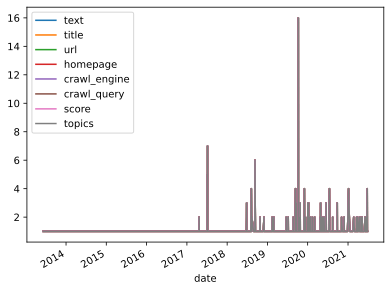

In [10]:
df = pd.DataFrame(climate_items)
df["date"] = pd.to_datetime(df["date"])
df = df[df["date"] <= "2021-06-30"]
df.groupby("date").count().plot()
# plt.xlim("2018-01-01", "2022-06-31")

In [28]:
from src.paths import interim_data

path = interim_data / "german_protest_reports"
labelpath = path / "labels"
labelpath.mkdir(exist_ok=True, parents=True)

schema = """
interface ClimateProtestEvent {
    IS_CLIMATE_PROTEST_EVENT: boolean;
    PAST_OR_FUTURE?: 'PAST' | 'FUTURE';
    CITY?: string;
    PROTEST_DATE_YEAR?: number;
    PROTEST_DATE_MONTH?: string; // January, February, March, April, May, June, July, August, September, October, November, December
    PROTEST_DATE_DAY?: number;
    PROTEST_GROUP?: ('FFF' | 'ALG' | 'XR' | 'EG' | 'GP' | 'OTHER_CLIMATE_GROUP')[], // Fridays for Future, (Aufstand) Letzte Generation, Extinction Rebellion, Ende Gelände, Greenpeace, other
    N_PARTICIPANTS?: number;
}
"""

template = """
```
let event1: ClimateProtestEvent = {
    IS_CLIMATE_PROTEST_EVENT: ,
    PAST_OR_FUTURE: '',
    CITY: '',
    PROTEST_DATE_YEAR: ,
    PROTEST_DATE_MONTH: ,
    PROTEST_DATE_DAY: ,
    PROTEST_GROUP: '',
    N_PARTICIPANTS: ,
};
"""

for i, row in df.sample(100, random_state=0).iterrows():
    with open(labelpath / f"{i}.txt", "w") as f:
        f.write(f"{row.title}\n\n{row.date.date()}\n\n{row.text}\n\n{template}")

In [53]:
import holidays

from src.data.protests.german_protest_reports.gpt import ask_gpt

system_prompt = f"""
Classify the following text as a climate protest event or not, and - if applicable - fill out the details. If there are multiple events, create a separate event object for each event. Use the following schema:

```{schema}```
"""

holiday_names = [i[0] for i in holidays.Germany(years=range(2018, 2023)).items()]

responses = []
for i, row in df.sample(10, random_state=1).iterrows():
    # get weekdays and holidays from the weeks before and after the protest
    date_helper_text = ""
    dates = pd.date_range(
        row.date - pd.Timedelta(days=7), row.date + pd.Timedelta(days=7)
    )
    for date in dates:
        # weekday
        date_helper_text += f"{date.strftime('%A')}, "
        # date
        date_helper_text += f"{date.day}. {date.month_name()} {date.year}"
        # holiday
        if date in holidays.Germany(years=range(2018, 2023)):
            date_helper_text += f", {holidays.Germany(years=range(2018, 2023))[date]}"
        date_helper_text += "\n"
    for date in dates:
        content = date_helper_text + "\n\n"
        content += f"{row.title}\n\n{row.date.date()}\n\n{row.text}"
        content += "\n\n```let event1: ClimateProtestEvent = {"
        print(system_prompt)
        print(content)
        response = ask_gpt(system_prompt, content)
        responses.append(response)


Classify the following text as a climate protest event or not. If there are multiple events, create a separate event object for each event. Use the following schema:

```
interface ClimateProtestEvent {
    IS_CLIMATE_PROTEST_EVENT: boolean;
    PAST_OR_FUTURE?: 'PAST' | 'FUTURE';
    CITY?: string;
    PROTEST_DATE_YEAR?: number;
    PROTEST_DATE_MONTH?: string; // January, February, March, April, May, June, July, August, September, October, November, December
    PROTEST_DATE_DAY?: number;
    PROTEST_GROUP?: 'FFF' | 'ALG' | 'XR' | 'EG' | 'GP' | 'OTHER_CLIMATE_GROUP';
    N_PARTICIPANTS?: number;
}
```

Friday, 14. February 2020
Saturday, 15. February 2020
Sunday, 16. February 2020
Monday, 17. February 2020
Tuesday, 18. February 2020
Wednesday, 19. February 2020
Thursday, 20. February 2020
Friday, 21. February 2020
Saturday, 22. February 2020
Sunday, 23. February 2020
Monday, 24. February 2020
Tuesday, 25. February 2020
Wednesday, 26. February 2020
Thursday, 27. February 2020
Friday